# Introduction

MelNet is a generative model for audio that works in 2D time-frequency representations such as spectrograms. However, audio usually comes in the form of waveform. Multiple transformations are required to go from waveform to melspectrogram (special type of spectrogram) and go back from melspectrogram to waveform.

The objective of this notebook is to see how much information is lost in each of the transformations and also compare the two libraries considered to be used in this project, torchaudio and librosa. This notebook will use the librispeech dataset.

In [1]:
import IPython

%matplotlib inline
import matplotlib.pyplot as plt
import torchaudio
import torch

import os,sys,inspect
sys.path.insert(0, "..")

from src.data import librispeech
from src.dataprocessing import transforms as T
from src.utils import hparams

pre_path = '../../'

In [2]:
path = "MelNet-SpeechGeneration/models/params/librispeech/librispeech_v1.yml"
hp = hparams.HParams.from_yaml(pre_path+path)
hp["device"] = "cpu"

In [3]:
librispeech = librispeech.download_data(root=pre_path+hp.data.path, url=hp.data.url)
dataloader_librispeech = torch.utils.data.DataLoader(librispeech)
dataiter = iter(dataloader_librispeech)

In [4]:
waveform1, sample_rate1, utterance1, speaker_id1, chapter_id1, utterance_id1 = dataiter.next()
waveform2, sample_rate2, utterance2, speaker_id2, chapter_id2, utterance_id2 = dataiter.next()

In [5]:
waveform1 = waveform1.to(hp.device)
waveform2 = waveform2.to(hp.device)

# Wave to Spectrogram and Spectrogram to Wave

In this transformation, we take the audio waveform, which is usually the representation used for storing audio and transform it to a spectrogram using the Short-Time Fourier Transform. Later, we take the spectrogram and transform it back to an audio waveform.

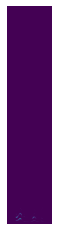

In [6]:
# Preparation and Transformation
spectrogram = T.wave_to_spectrogram(waveform1, hp)
T.plot_spectrogram(spectrogram, hp)

Waveform 0, shape: torch.Size([1, 40640])
Waveform 0, Sample rate: 16000


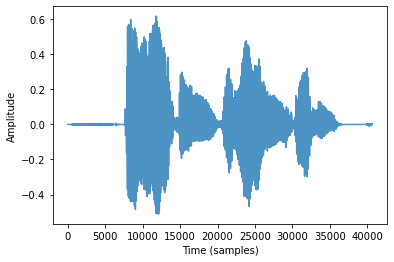

In [7]:
# Original waveform
T.plot_wave(waveform1, hp)

Waveform 0, shape: torch.Size([1, 40448])
Waveform 0, Sample rate: 16000


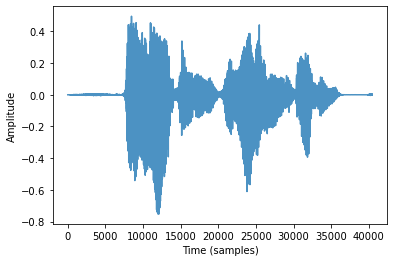

In [8]:
# Reconstructed
wave_rec = T.spectrogram_to_wave(spectrogram, hp, n_iter=32)
T.plot_wave(wave_rec, hp)

In [9]:
# Information loss: measurd by difference between waves
print("Size original wave: ", waveform1.flatten().shape, " Size reconstructed wave: ", wave_rec.flatten().shape)
print("Absolute difference: ", torch.sum(torch.abs(wave_rec-waveform1.flatten()[:40448])))
print("Relative difference: ", torch.sum(torch.abs(wave_rec-waveform1.flatten()[:40448]))/torch.sum(torch.abs(waveform1.flatten()[:40448])))

Size original wave:  torch.Size([40640])  Size reconstructed wave:  torch.Size([40448])
Absolute difference:  tensor(2728.8599)
Relative difference:  tensor(1.0486)


Above, we can see that the relative difference between the original waveform and the reconstructed waveform is pretty big. However, this information can not be compared and to really know how much information has been lost, the best option is to listen to the audio waveforms.

In [10]:
print("Original:")
IPython.display.Audio(data=waveform1.flatten().detach().to('cpu').numpy(), rate=hp.audio.sample_rate)

Original:


In [11]:
print("Reconstructed:")
IPython.display.Audio(data=wave_rec.flatten().detach().to('cpu').numpy(), rate=hp.audio.sample_rate)

Reconstructed:


These are the shapes of the data and how they will work in all the project.
* **Audio waveforms**: 3 dimensional tensor with (batchsize, 1, length)
* **Spectrograms (including other types like melspectrograms)**: 3 dimensional tensor with (batchsize, frequencies, frames)

In [12]:
print("Wave:        ", waveform1.shape, " Shape: [B, 1, L]")
print("Spectrogram: ", spectrogram.shape, " Shape: [B, FREQ, FRAMES]")
print("Wave_rec:    ", wave_rec.shape, " Shape: [B, 1, L']")

Wave:         torch.Size([1, 1, 40640])  Shape: [B, 1, L]
Spectrogram:  torch.Size([1, 769, 159])  Shape: [B, FREQ, FRAMES]
Wave_rec:     torch.Size([1, 1, 40448])  Shape: [B, 1, L']


## Spectrogram to Spectrogram dB and Spectrogram dB to Spectrogram
In this transformation, we take the spectrogram, which represents time in the horizontal axis, frequency in the vertical axis, and amplitude of the $j^th$ frequency at the $i^th$ timestep. To better align this representation with how humans perceive sound, the amplitude is transformed into the decibel scale, which is a logirithmic transformation.

In [13]:
# Preparation
spectrogram = T.wave_to_spectrogram(waveform1, hp)

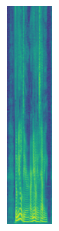

In [14]:
# Transformation
spectrogram_db = T.amplitude_to_db(spectrogram, hp)
T.plot_spectrogram(spectrogram_db, hp)

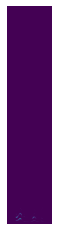

In [15]:
# Original
T.plot_spectrogram(spectrogram, hp)

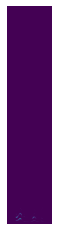

In [16]:
# Reconstructed
spectrogram_rec_from_db = T.db_to_amplitude(spectrogram_db, hp)
T.plot_spectrogram(spectrogram_rec_from_db, hp)

In [17]:
# difference between spectrograms
print("Absolute difference: ",torch.sum(torch.abs(spectrogram_rec_from_db-spectrogram)))
print("Relative difference: ", torch.sum(torch.abs(spectrogram_rec_from_db-spectrogram))/torch.sum(torch.abs(spectrogram)))

Absolute difference:  tensor(0.2094)
Relative difference:  tensor(2.2273e-07)


Above, we can see the relative difference between the original spectrogram and the reconstructed spectrogram from the decibel scale. We can see that because the transformation is logarithmic, and thus a reversible transformation, there is almost no information loss.

In [18]:
print("Spectrogram:             ", spectrogram.shape, " Shape: [B, FREQ, FRAMES]")
print("Spectrogram_db:          ", spectrogram_db.shape, " Shape: [B, FREQ, FRAMES]")
print("Spectrogram_rec_from_db: ", spectrogram_rec_from_db.shape, " Shape: [B, FREQ, FRAMES]")

Spectrogram:              torch.Size([1, 769, 159])  Shape: [B, FREQ, FRAMES]
Spectrogram_db:           torch.Size([1, 769, 159])  Shape: [B, FREQ, FRAMES]
Spectrogram_rec_from_db:  torch.Size([1, 769, 159])  Shape: [B, FREQ, FRAMES]


## Spectrogram to MelSpectrogram and MelSpectrogram to Spectrogram
In this transformation, we take the spectrogram, which represents time in the horizontal axis, frequency in the vertical axis, and amplitude of the  𝑗𝑡ℎ  frequency at the  𝑖𝑡ℎ  timestep. To better align this representation with how humans perceive sound, the frequency is transformed into the MelScale.

In [19]:
# Preparation
spectrogram = T.wave_to_spectrogram(waveform1, hp)

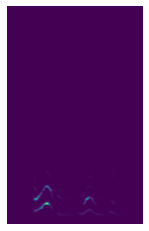

In [20]:
# Transformation
melspectrogram = T.spectrogram_to_melspectrogram(spectrogram, hp)
T.plot_melspectrogram(melspectrogram, hp)

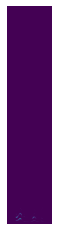

In [21]:
# Original
T.plot_spectrogram(spectrogram, hp)

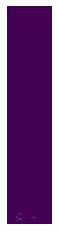

In [22]:
# Reconstructed
spectrogram_rec_from_mel = T.melspectrogram_to_spectrogram(melspectrogram, hp)
T.plot_spectrogram(spectrogram_rec_from_mel, hp)

In [23]:
# difference between spectrograms
print("Absolute difference: ", torch.sum(torch.abs(spectrogram_rec_from_mel-spectrogram)))
print("Relative difference: ",torch.sum(torch.abs(spectrogram_rec_from_mel-spectrogram))/torch.sum(torch.abs(spectrogram)))

Absolute difference:  tensor(10949.7070)
Relative difference:  tensor(0.0116)


Above, we can see the relative difference between the original spectrogram and the reconstructed spectrogram from the mel scale. We can see that there is almost no information loss.

In [24]:
print("Spectrogram:              ", spectrogram.shape, " Shape: [B, FREQ, FRAMES]")
print("Melspectrogram:           ", melspectrogram.shape, " Shape: [B, N_MELS, FRAMES]")
print("Spectrogram_rec_from_mel: ", spectrogram_rec_from_mel.shape, " Shape: [B, FREQ, FRAMES]")

Spectrogram:               torch.Size([1, 769, 159])  Shape: [B, FREQ, FRAMES]
Melspectrogram:            torch.Size([1, 256, 159])  Shape: [B, N_MELS, FRAMES]
Spectrogram_rec_from_mel:  torch.Size([1, 769, 159])  Shape: [B, FREQ, FRAMES]


## MelSpectrogram to MelSpectrogram dB and MelSpectrogram dB to MelSpectrogram
In this transformation, we take the melspectrogram and to better align this representation with how humans perceive sound, the amplitude is transformed into the decibel scale, which is a logirithmic transformation. This representation, a melspectrogram in the decibel scale, is what MelNet works with (its input and output) and the best representation to appreciate sound according to how humans perceive sound because both amplitude and frequencies have been aligned.

In [25]:
# Preparation
melspectrogram = T.wave_to_melspectrogram(waveform1, hp)

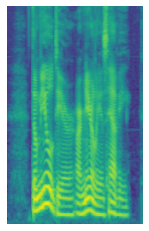

In [26]:
# Transformation
melspectrogram_db = T.amplitude_to_db(melspectrogram, hp)
T.plot_melspectrogram(melspectrogram_db, hp)

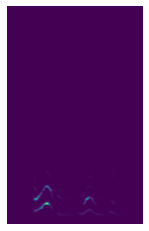

In [27]:
# Original
T.plot_melspectrogram(melspectrogram, hp)

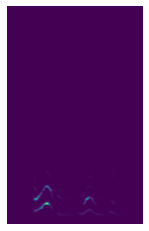

In [28]:
# reconstructed
melspectrogram_rec_from_db = T.db_to_amplitude(melspectrogram_db, hp)
T.plot_melspectrogram(melspectrogram_rec_from_db, hp)

In [29]:
# difference between spectrograms
print("Absolute difference: ", torch.sum(torch.abs(melspectrogram_rec_from_db-melspectrogram)))
print("Relative difference: ", torch.sum(torch.abs(melspectrogram_rec_from_db-melspectrogram))/torch.sum(torch.abs(melspectrogram)))

Absolute difference:  tensor(0.2382)
Relative difference:  tensor(2.5332e-07)


Above, we can see the relative difference between the original melspectrogram and the reconstructed melspectrogram from the decibel scale. We can see that because the transformation is logarithmic, and thus a reversible transformation, there is almost no information loss.

In [30]:
print("Melspectrogram:             ", melspectrogram.shape, " Shape: [B, N_MELS, FREQ]")
print("Melspectrogram_db:          ", melspectrogram_db.shape, " Shape: [B, N_MELS, FREQ]")
print("Melspectrogram_rec_from_db: ", melspectrogram_rec_from_db.shape, " Shape: [B, N_MELS, FREQ]")

Melspectrogram:              torch.Size([1, 256, 159])  Shape: [B, N_MELS, FREQ]
Melspectrogram_db:           torch.Size([1, 256, 159])  Shape: [B, N_MELS, FREQ]
Melspectrogram_rec_from_db:  torch.Size([1, 256, 159])  Shape: [B, N_MELS, FREQ]


## Complete Pipeline
Now that we have seen the effect of the transformations isolated, we are going to do all the transformations sequentially, from the waveform until the melspectrogram in decibel scale and back. Later, we will compare the original waveform and the reconstructed waveform. If both audios are the same when listening to them, we will be able to conclude that these transformations applied sequentially do not have a great information loss.

In [31]:
# Wave -> Spectrogram -> MelSpectrogram -> 
# MelSpectrogram dB -> MelSpectrogram - Wave 
wave_orig = waveform1
spectrogram_orig = T.wave_to_spectrogram(wave_orig, hp)
melspectrogram_orig = T.spectrogram_to_melspectrogram(spectrogram_orig, hp)
melspectrogram_db_orig = T.amplitude_to_db(melspectrogram_orig, hp)
melspectrogram_rec = T.db_to_amplitude(melspectrogram_db_orig, hp)
spectrogram_rec = T.melspectrogram_to_spectrogram(melspectrogram_rec, hp)
wave_rec = T.spectrogram_to_wave(spectrogram_rec, hp, n_iter=1000)

In [32]:
# difference between waves
print(wave_orig.shape, wave_rec.shape)
print("Absoulte diffference: ", torch.sum(torch.abs(wave_rec.flatten()-wave_orig.flatten()[:wave_rec.size(2)])))
print("Relative difference: ", torch.sum(torch.abs(wave_rec.flatten()-wave_orig.flatten()[:wave_rec.size(2)]))/torch.sum(torch.abs(wave_orig.flatten()[:wave_rec.size(2)])))

torch.Size([1, 1, 40640]) torch.Size([1, 1, 40448])
Absoulte diffference:  tensor(3731.9519)
Relative difference:  tensor(1.4340)


As we said in the first section, we can not really compare the relative difference and the best option to know the information loss is to listen to the audio waveforms.

Waveform 0, shape: torch.Size([1, 40640])
Waveform 0, Sample rate: 16000


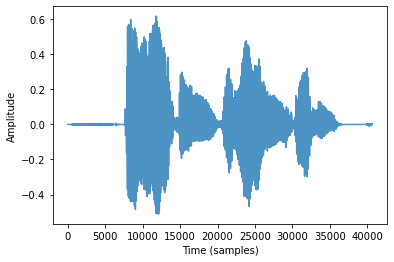

In [33]:
# Original
T.plot_wave(wave_orig, hp)

Waveform 0, shape: torch.Size([1, 40448])
Waveform 0, Sample rate: 16000


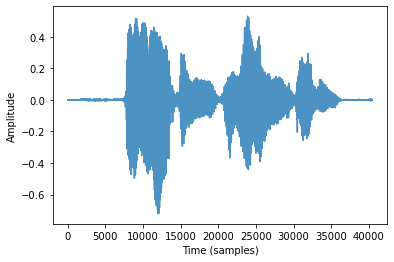

In [34]:
# Reconstructed
T.plot_wave(wave_rec, hp)

In [35]:
print("Original:")
IPython.display.Audio(data=wave_orig.flatten().detach().to('cpu').numpy(), rate=hp.audio.sample_rate)

Original:


In [36]:
print("Reconstructed:")
IPython.display.Audio(data=wave_rec.flatten().detach().to('cpu').numpy(), rate=hp.audio.sample_rate)

Reconstructed:


Looking at the plots of the waveforms, which are pretty similar, and listening to the original audio and the recovered audio, which sound pretty similar, we can conclude that these transformation do not affect the quality of the sound and that the information loss is negligible.

## Impact of applying decibel scale transformation before  mel scale transformation
Looking at theory about these transfomations, there was no information about which transformation should be applied before, if decibel scale or mel scale. Above in the notebook, we have seen the effects of applying mel scale transformation before decibel scale transformation. In this section, we will see what happens if the order is inverted.

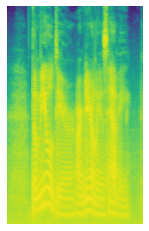

In [37]:
# waveform -> linear spectrogram -> amplitude to db -> mel spectrogram
spectrogram = T.wave_to_spectrogram(waveform1, hp)
spectrogram_db = T.amplitude_to_db(spectrogram, hp)
melspectrogram_db = T.spectrogram_to_melspectrogram(spectrogram_db, hp)
T.plot_melspectrogram(melspectrogram_db, hp)

Compared with the result of applying melscale transformation first, this transformation makes the image of the spectrogram look like more wash out.

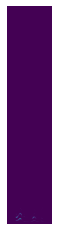

In [38]:
# Original
T.plot_melspectrogram(spectrogram, hp)

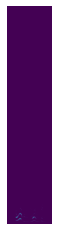

In [39]:
# reconstructed
spectrogram_db_rec = T.melspectrogram_to_spectrogram(melspectrogram_db, hp)
spectrogram_rec = T.db_to_amplitude(spectrogram_db_rec, hp)
T.plot_spectrogram(spectrogram_rec, hp)

Now, we will do the transformations in the other order and later we will compare the information loss.

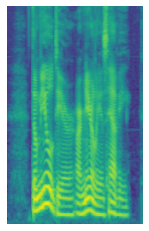

In [40]:
# waveform -> linear spectrogram -> mel spectrogram -> amplitude to db
spectrogram2 = T.wave_to_spectrogram(waveform1, hp)
melspectrogram2 = T.spectrogram_to_melspectrogram(spectrogram2, hp)
melspectrogram_db2 = T.amplitude_to_db(melspectrogram2, hp)
T.plot_melspectrogram(melspectrogram_db2, hp)

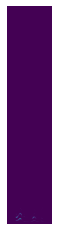

In [41]:
# Original
T.plot_melspectrogram(spectrogram2, hp)

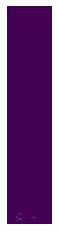

In [42]:
# reconstructed
melspectrogram_rec2 = T.db_to_amplitude(melspectrogram_db2, hp)
spectrogram_rec2 = T.melspectrogram_to_spectrogram(melspectrogram_rec2, hp)
T.plot_spectrogram(spectrogram_rec2, hp)

In [43]:
# difference between spectrograms
print("Spectrogram -> Spectrogram in dB -> Melspectrogram in dB")
print("Absolute difference: ", torch.sum(torch.abs(spectrogram_rec-spectrogram)))
print("Relative difference: ", torch.sum(torch.abs(spectrogram_rec-spectrogram))/torch.sum(torch.abs(spectrogram)))

# difference between spectrograms
print("Spectrogram -> Melspectrogram -> Melspectrogram in dB")
print("Absolute difference: ", torch.sum(torch.abs(spectrogram_rec2-spectrogram2)))
print("Relative difference: ", torch.sum(torch.abs(spectrogram_rec2-spectrogram2))/torch.sum(torch.abs(spectrogram2)))

Spectrogram -> Spectrogram in dB -> Melspectrogram in dB
Absolute difference:  tensor(541228.2500)
Relative difference:  tensor(0.5756)
Spectrogram -> Melspectrogram -> Melspectrogram in dB
Absolute difference:  tensor(10934.5547)
Relative difference:  tensor(0.0116)


Above, we can see the relative difference between the original spectrogram and the reconstructed spectrogram in both cases. From these results, we can conclude that it is better to apply the melscale transformation before because it has less information loss. However, we still need to see how this affects audio in the complete pipeline.

# Complete pipeline applying decibel scale before mel scale
We are going to apply the complete transformation pipeline but applying first the decibel scale. Looking ath the image representation, it seems like this approach is worst than applying the mel scale transformation first but here we are going to see the effect that this has in the final audio.

In [44]:
# Wave -> Spectrogram -> Spectrogram dB-> 
# MelSpectrogram dB -> Spectrogram dB -> Wave 
wave_orig = waveform1
spectrogram_orig = T.wave_to_spectrogram(wave_orig, hp)
spectrogram_db_orig = T.amplitude_to_db(spectrogram_orig, hp)
melspectrogram_db_orig = T.spectrogram_to_melspectrogram(spectrogram_db_orig, hp)
spectrogram_db_rec = T.melspectrogram_to_spectrogram(melspectrogram_db_orig, hp)
spectrogram_rec = T.db_to_amplitude(spectrogram_db_rec, hp)
wave_rec = T.spectrogram_to_wave(spectrogram_rec, hp, n_iter=1000)

In [45]:
# difference between waves
print(wave_orig.shape, wave_rec.shape)
print("Absoulte diffference: ", torch.sum(torch.abs(wave_rec.flatten()-wave_orig.flatten()[:wave_rec.size(2)])))
print("Relative difference: ", torch.sum(torch.abs(wave_rec.flatten()-wave_orig.flatten()[:wave_rec.size(2)]))/torch.sum(torch.abs(wave_orig.flatten()[:wave_rec.size(2)])))

torch.Size([1, 1, 40640]) torch.Size([1, 1, 40448])
Absoulte diffference:  tensor(4005.6875)
Relative difference:  tensor(1.5392)


Waveform 0, shape: torch.Size([1, 40640])
Waveform 0, Sample rate: 16000


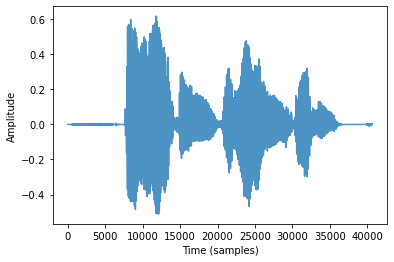

In [46]:
# Original
T.plot_wave(wave_orig, hp)

Waveform 0, shape: torch.Size([1, 40448])
Waveform 0, Sample rate: 16000


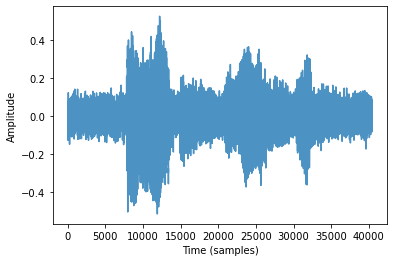

In [47]:
T.plot_wave(wave_rec, hp)

In [48]:
print("Original:")
IPython.display.Audio(data=wave_orig.flatten().detach().to('cpu').numpy(), rate=hp.audio.sample_rate)

Original:


In [49]:
print("Reconstructed:")
IPython.display.Audio(data=wave_rec.flatten().detach().to('cpu').numpy(), rate=hp.audio.sample_rate)

Reconstructed:


Looking at the plots of the waveforms, we can see that this approach introduces noise into the waveform, and listening to the original audio and the recovered audio, we can clearly listen to this noise. In conclusion, applying decibel scale transformation first produces bad results and it should be preferred to apply the mel scale transformation first.